In [113]:
import sys
# sys.path.append('/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/eth-capstone-treewater-deficit/src')
sys.path.append('/workspaces/eth-capstone-treewater-deficit/src')
import os
import glob 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

import plotly.express as px
import plotly.graph_objects as go

import collections

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import  r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras as tf_keras

from sklearn.preprocessing import StandardScaler
from treewater.utils import *

In [114]:
import importlib
import treewater.utils as utils
importlib.reload(utils)

# check presence
print(hasattr(utils, "build_autoregressive_training_data_fast_LSTM_scheduled"))
print(hasattr(utils, "teacher_forcing_prob"))
print(hasattr(utils, "cross_validation_LSTM_FT"))

True
True
True


In [115]:
# set global random seed
seed = 66666
tf.random.set_seed(
    seed
)

In [116]:
# # At top of notebook
# %load_ext autoreload
# %autoreload 2

# from treewater.utils import *

In [16]:
# derived_path = "/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/data"
# data_dir = "/cluster/home/taoj/work_dir/eth-caipstone/tree-water-deficit/data/tstoy04"
data_dir = "/workspaces/eth-capstone-treewater-deficit/data/tstoy04"
derived_path = "/workspaces/eth-capstone-treewater-deficit/data"

In [17]:
df_series_all = pd.read_csv(os.path.join(derived_path, "twd_tree_series_all.csv"))
twd_tree_series_sites = pd.read_csv(os.path.join(derived_path, "twd_tree_series_sites.csv"))

In [18]:
df_series_all.head(5)
# twd_tree_series_sites.head(10)

,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,Wt,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_03,Bachtel-Forest,Fagus sylvatica,1,NaN,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_03,Bachtel-Forest,Fagus sylvatica,1,0.121408,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_03,Bachtel-Forest,Fagus sylvatica,1,-0.003137,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_03,Bachtel-Forest,Fagus sylvatica,1,-0.118271,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_03,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01


## data preparation

In [19]:
# test if in the same day same site, temp and other features are the same

sites = df_series_all['site_name'].unique()
for site in sites:
    df_site = df_series_all.loc[df_series_all.site_name == site, ]
    series = df_site.series_no.unique()
    if len(series) >=2:
        series_1 = df_site.loc[df_site.series_no == series[0], ]
        series_2 = df_site.loc[df_site.series_no == series[1], ]
        merged = pd.merge(series_1, series_2, on='ts', suffixes=('_1', '_2'))
        temp_equal = all(merged['at_1'] == merged['at_2'])
        pr_equal = all(merged['pr_1'] == merged['pr_2'])
        dp_equal = all(merged['dp_1'] == merged['dp_2'])
        sr_equal = all(merged['sr_1'] == merged['sr_2'])
        if not (temp_equal and pr_equal and dp_equal and sr_equal):
            print(f"Data mismatch found in site {site} between series {series[0]} and {series[1]}")

# so far they are no mismatch found, all the other measurements are the same for different series in the same site


In [20]:
# twd_tree_series_sites

In [21]:
# Psudotsuga mnzisii", from site "Multi-Forest" in 2021, 2022 exluded
df_series_all = df_series_all.loc[~((df_series_all.species == "Psudotsuga mnzisii") & (df_series_all.site_name == "Multi-Forest") & (df_series_all.year.isin([2021, 2022]))), ]
df_series_all_median = df_series_all.groupby(['site_name', 'species', 'ts']).agg({'twd': 'median',  'year': 'first',
                                                                                 'pr': 'median', 'at': 'median', "ws": 'median', 'dp': 'median',
                                                                                 'sr': 'median', 'lr':'median'}).reset_index() 

df_series_all_median= df_series_all_median.merge(twd_tree_series_sites[['site_name', 'species', 'mch_elevation', "mch_easting",
                                                                        "mch_northing"]].drop_duplicates(), on=['site_name', 'species'], how='left')

In [22]:
# transform species to categorical variable - using ohe-hot encoding
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df_series_all_median['species'],dtype=float)
# Drop column B as it is now encoded, hmm maybe not yet
df_series_all_features = df_series_all_median
# Join the encoded df
df_series_all_features = df_series_all_features.join(one_hot.iloc[: , 0:6])
# drop useless features 
df_series_features = df_series_all_features.drop(columns=['year'])

In [23]:
# create a dataframe with log2 transformed twd values
df_series_features_log2 = df_series_features.copy()
epsilon = 1e-6
df_series_features_log2['twd'] = np.log2(epsilon+ df_series_features_log2['twd'])

split the data into training and test set
 - train and test set split by an even distribution of sites? 
 - easting and northing recommended
 - if autoregressive with lag =13
    - label: twd_t
    - input feature: [twd_t-12, twd_t-11, ...twd_t-1, at_t-1, lt_t-1]? 
    - can i use at_t as input feature?


Normalize certain colums: 

- pr	at	ws	dp	sr	lr	mch_elevation	site_longitude	site_latitude
- if twd was treated as feature should we then standardize it when model is autoregressive? 
- should we normalize it before or after splitting by windows? - i guess really no harm either way 

In [24]:
# Configure features
config = FeatureConfig()
lag_n =13

# Autoregressive
# Split data
train_df_at, val_df_at, test_df_at = create_training_test_set_optimized(
    df_series_features,
    feature_window_size=lag_n,
    autoregressive=True
)

train_df_at, val_df_at, test_df_at = standardize_dataset(
    train_df_at, val_df_at, test_df_at,
    config
)

# Create windows
train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at,  train_y_at = get_dataset_LSTM(
    train_df_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=True,
    shift = 1,
    config=config
)

val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at, val_y_at = get_dataset_LSTM(
    val_df_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=True,
    shift = 1,
    config=config
)





2025-12-14 10:14:17.470785: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### build LSTM
- LSTM 
- RNN
- and perhaps try elastic net to improve ridgeregression model performance, and try gaussian regressor

In [25]:

batch_size = 64
lag_n = 13

### Autoregressive
- reduce hidden space size to prevent overfitting

In [ ]:
# building datasets
batch_size = batch_size

train_ds_at = tf.data.Dataset.from_tensor_slices((
    (train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at),
    train_y_at,
))
train_ds_at = (
    train_ds_at
    .shuffle(buffer_size=len(train_X_ts_at))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds_at = tf.data.Dataset.from_tensor_slices((
    (val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at),
    val_y_at,
))
val_ds_at = (
    val_ds_at
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


# create cross validate datasets tensorflow datasets

train_val_datasets_at = cross_validate_datasets(train_df_at, n_splits=4, feature_window_size=lag_n, config=config)

# build tf.data.Dataset for each fold
cv_train_val_ds_at = []
for train_cv_df_at, val_cv_df_at in train_val_datasets_at:
    
    train_cv_ds_at = build_ds_from_get_dataset_LSTM(
        train_cv_df_at ,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        shift=1,
        batch_size=batch_size,
    )
    val_cv_ds_at = build_ds_from_get_dataset_LSTM(
        val_cv_df_at,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        shift=1,
        batch_size=batch_size,
    )
    cv_train_val_ds_at.append((train_cv_ds_at, val_cv_ds_at))

    

In [27]:
# dynamic input
def build_autoregressive_model_lstm( train_X_ts_at, train_day_feat_X, train_static_X_ts, lag_n, hidden_unit = 16):
     # we don't actually need the input features but rather the shape information
    timesteps = lag_n
    n_features = train_X_ts_at.shape[2] # include TWD + other variables

    dyn_in = tf_keras.layers.Input(shape=(timesteps, n_features), name="past_dynamic")
    x_dyn = tf_keras.layers.LSTM(hidden_unit, return_sequences=False)(dyn_in)
    x_dyn = tf_keras.layers.Dense(hidden_unit, activation="relu")(x_dyn)

    # current day other features
    n_static = train_day_feat_X.shape[1]
    static_in = tf_keras.Input(shape=(n_static,), name="current_day_exog")
    x_static = tf_keras.layers.Dense(4, 
                                     activation="relu",
                                     kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                                     )(static_in)

    # static input
    n_current = train_static_X_ts.shape[1]
    curr_in = tf_keras.Input(shape=(n_current,), name="static")
    x_curr = tf_keras.layers.Dense(4, 
                                   activation="relu",
                                   kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                                   )(curr_in)


    combined = tf_keras.layers.Concatenate()([x_dyn, x_static, x_curr])
    x = tf_keras.layers.Dense(16, activation="relu")(combined)
    out = tf_keras.layers.Dense(1, activation = "softplus")(x)


    model_at = tf_keras.Model(
    inputs=[dyn_in, static_in, curr_in],
    outputs=out,
    )

    model_at.compile(
        optimizer=tf_keras.optimizers.Adam(),
        loss="mse",
        metrics=[
        tf_keras.metrics.RootMeanSquaredError(name="rmse"),
        tf_keras.metrics.MeanAbsoluteError(name="mae"),
    ],
    )
    return model_at

In [28]:
# building datasets
batch_size = batch_size

train_ds_at = tf.data.Dataset.from_tensor_slices((
    (train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at),
    train_y_at,
))
train_ds_at = (
    train_ds_at
    .shuffle(buffer_size=len(train_X_ts_at))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds_at = tf.data.Dataset.from_tensor_slices((
    (val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at),
    val_y_at,
))
val_ds_at = (
    val_ds_at
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


# create cross validate datasets tensorflow datasets

train_val_datasets_at = cross_validate_datasets(train_df_at, n_splits=4, feature_window_size=lag_n, config=config)

# build tf.data.Dataset for each fold
cv_train_val_ds_at = []
for train_cv_df_at, val_cv_df_at in train_val_datasets_at:
    
    train_cv_ds_at = build_ds_from_get_dataset_LSTM(
        train_cv_df_at ,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        shift=1,
        batch_size=batch_size,
    )
    val_cv_ds_at = build_ds_from_get_dataset_LSTM(
        val_cv_df_at,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        shift=1,
        batch_size=batch_size,
    )
    cv_train_val_ds_at.append((train_cv_ds_at, val_cv_ds_at))

    



In [29]:
# # quick per-fold diagnostics
# for i, (train_cv_df_at, val_cv_df_at) in enumerate(train_val_datasets_at):
#     print(f"Fold {i+1}")
#     print("  n_rows (val):", len(val_cv_df_at))
#     print("  n_rows (train):", len(train_cv_df_at))
#     print("  sites in val:", val_cv_df_at['site_name'].nunique(), "species:", val_cv_df_at['species'].nunique())
#     print("  site counts:", val_cv_df_at['site_name'].value_counts().to_dict())
#     print("  twd mean/std:", val_cv_df_at['twd'].mean(), val_cv_df_at['twd'].std())
#     # how many windows are produced for this val fold
#     X_ts, day_feat, static, y = get_dataset_LSTM(val_cv_df_at, feature_window_size=lag_n, autoregressive=True, shift=1, config=config)
#     print("  n_windows(val):", X_ts.shape[0])
#     print("-"*40)

In [30]:
# create two models with different hidden units 

model_fold1 = build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at, lag_n, hidden_unit = 16)
maes_cv_at, rmses_cv_at, rmses_cv_1d_at, r2s_cv_1d_at, r2s_cv_at, y_preds_cv_at, y_trues_cv_at, historys_cv_at = cross_validation_LSTM(
    model_fold1,
    cv_train_val_ds_at,
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n,
    config,
    batch_size
)
model_fold2 = build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at , lag_n, hidden_unit = 32)
maes_cv_at2, rmses_cv_at2, rmses_cv_1d_at2, r2s_cv_1d_at2, r2s_cv_at2, y_preds_cv_at2, y_trues_cv_at2, historys_cv_at2  = cross_validation_LSTM(
    model_fold2,
    cv_train_val_ds_at,
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n,
    config,
    batch_size
)


Training fold 1/4
Epoch 1/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.6882 - mae: 0.5766 - rmse: 0.8252 - val_loss: 0.5318 - val_mae: 0.4999 - val_rmse: 0.7243
Epoch 2/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5647 - mae: 0.5120 - rmse: 0.7468 - val_loss: 0.5904 - val_mae: 0.4913 - val_rmse: 0.7638
Epoch 3/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4715 - mae: 0.4670 - rmse: 0.6816 - val_loss: 0.6230 - val_mae: 0.4936 - val_rmse: 0.7850
Epoch 4/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3811 - mae: 0.4159 - rmse: 0.6118 - val_loss: 0.6175 - val_mae: 0.4916 - val_rmse: 0.7815
Epoch 5/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2903 - mae: 0.3619 - rmse: 0.5326 - val_loss: 0.5904 - val_mae: 0.4845 - val_rmse: 0.7640
Epoch 6/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2105 - mae: 0.3117 - rmse: 0.4516 - val_loss: 0.5611 - val_mae: 0.4762 - val_rmse: 0.7447
Epoch 7/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1743 - mae: 0.2896 - 

2025-12-14 10:14:32.482176: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training fold 2/4
Epoch 1/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0675 - mae: 0.1763 - rmse: 0.2512 - val_loss: 0.1690 - val_mae: 0.2828 - val_rmse: 0.4058
Epoch 2/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0621 - mae: 0.1665 - rmse: 0.2404 - val_loss: 0.1268 - val_mae: 0.2306 - val_rmse: 0.3501
Epoch 3/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0531 - mae: 0.1514 - rmse: 0.2210 - val_loss: 0.1237 - val_mae: 0.2231 - val_rmse: 0.3458
Epoch 4/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0504 - mae: 0.1460 - rmse: 0.2151 - val_loss: 0.1214 - val_mae: 0.2203 - val_rmse: 0.3427
Epoch 5/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0478 - mae: 0.1406 - rmse: 0.2093 - val_loss: 0.1174 - val_mae: 0.2122 - val_rmse: 0.3368
Epoch 6/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0461 - mae: 0.1372 - rmse: 0.2055 - val_loss: 0.1162 - val_mae: 0.2103 - val_rmse: 0.3352
Epoch 7/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0449 - mae: 0.1350 - r

2025-12-14 10:15:02.737063: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training fold 3/4
Epoch 1/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0570 - mae: 0.1414 - rmse: 0.2354 - val_loss: 0.0340 - val_mae: 0.1125 - val_rmse: 0.1802
Epoch 2/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0827 - mae: 0.1727 - rmse: 0.2850 - val_loss: 0.0394 - val_mae: 0.1317 - val_rmse: 0.1948
Epoch 3/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0626 - mae: 0.1481 - rmse: 0.2474 - val_loss: 0.0336 - val_mae: 0.1152 - val_rmse: 0.1795
Epoch 4/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0520 - mae: 0.1316 - rmse: 0.2250 - val_loss: 0.0334 - val_mae: 0.1132 - val_rmse: 0.1790
Epoch 5/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0504 - mae: 0.1295 - rmse: 0.2214 - val_loss: 0.0340 - val_mae: 0.1150 - val_rmse: 0.1805
Epoch 6/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0499 - mae: 0.1293 - rmse: 0.2202 - val_loss: 0.0350 - val_mae: 0.1166 - val_rmse: 0.1835
Epoch 7/40
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0495 - m

2025-12-14 10:16:19.441807: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training fold 1/4
Epoch 1/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6871 - mae: 0.5925 - rmse: 0.8215 - val_loss: 0.5599 - val_mae: 0.5244 - val_rmse: 0.7404
Epoch 2/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4422 - mae: 0.4479 - rmse: 0.6562 - val_loss: 0.6057 - val_mae: 0.4918 - val_rmse: 0.7709
Epoch 3/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2535 - mae: 0.3350 - rmse: 0.4924 - val_loss: 0.6271 - val_mae: 0.4891 - val_rmse: 0.7850
Epoch 4/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1643 - mae: 0.2782 - rmse: 0.3920 - val_loss: 0.5651 - val_mae: 0.4723 - val_rmse: 0.7447
Epoch 5/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1298 - mae: 0.2540 - rmse: 0.3458 - val_loss: 0.5186 - val_mae: 0.4556 - val_rmse: 0.7131
Epoch 6/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1111 - mae: 0.2333 - rmse: 0.3180 - val_loss: 0.4572 - val_mae: 0.4331 - val_rmse: 0.6688
Epoch 7/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1013 - mae: 0.2204 - 

2025-12-14 10:18:38.849944: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [72]:
# # print cv results
# print("Autoregressive Model with 16 hidden units:")
# print("="*60)
# print("Cross-Validation Results (Autoregressive Model)")
# print("="*60)
# print(f"Number of folds: {len(maes_cv_at)}\n")

# for i in range(len(maes_cv_at)):
#     print(f"Fold {i+1}:")
#     print(f"  MAE (1-day):        {maes_cv_at[i]:.4f}")
#     print(f"  RMSE (1-day):       {rmses_cv_1d_at[i]:.4f}")
#     print(f"  RMSE (recursive):   {rmses_cv_at[i]:.4f}")
#     print(f"  R² (1-day):        {r2s_cv_1d_at[i]:.4f}")
#     print(f"  R² (recursive):     {r2s_cv_at[i]:.4f}")
#     print()

# print("-"*60)
# print("Average Performance Across All Folds:")
# print(f"  MAE (1-day):        {np.mean(maes_cv_at):.4f} ± {np.std(maes_cv_at):.4f}")
# print(f"  RMSE (1-day):       {np.mean(rmses_cv_1d_at):.4f} ± {np.std(rmses_cv_1d_at):.4f}")
# print(f"  RMSE (recursive):   {np.mean(rmses_cv_at):.4f} ± {np.std(rmses_cv_at):.4f}")
# print(f"  R² (1-day):        {np.mean(r2s_cv_1d_at):.4f} ± {np.std(r2s_cv_1d_at):.4f}")
# print(f"  R² (recursive):     {np.mean(r2s_cv_at):.4f} ± {np.std(r2s_cv_at):.4f}")
# print("="*60)

In [73]:
# # print cv results
# print("Autoregressive Model with 32 hidden units:")
# print("="*60)
# print("Cross-Validation Results (Autoregressive Model)")
# print("="*60)
# print(f"Number of folds: {len(maes_cv_at)}\n")

# for i in range(len(maes_cv_at)):
#     print(f"Fold {i+1}:")
#     print(f"  MAE (1-day):        {maes_cv_at2[i]:.4f}")
#     print(f"  RMSE (1-day):       {rmses_cv_1d_at2[i]:.4f}")
#     print(f"  RMSE (recursive):   {rmses_cv_at2[i]:.4f}")
#     print(f"  R² (1-day):        {r2s_cv_1d_at2[i]:.4f}")
#     print(f"  R² (recursive):     {r2s_cv_at2[i]:.4f}")
#     print()

# print("-"*60)
# print("Average Performance Across All Folds:")
# print(f"  MAE (1-day):        {np.mean(maes_cv_at2):.4f} ± {np.std(maes_cv_at2):.4f}")
# print(f"  RMSE (1-day):       {np.mean(rmses_cv_1d_at2):.4f} ± {np.std(rmses_cv_1d_at2):.4f}")
# print(f"  RMSE (recursive):   {np.mean(rmses_cv_at2):.4f} ± {np.std(rmses_cv_at2):.4f}")
# print(f"  R² (1-day):        {np.mean(r2s_cv_1d_at2):.4f} ± {np.std(r2s_cv_1d_at2):.4f}")
# print(f"  R² (recursive):     {np.mean(r2s_cv_at2):.4f} ± {np.std(r2s_cv_at2):.4f}")
# print("="*60)

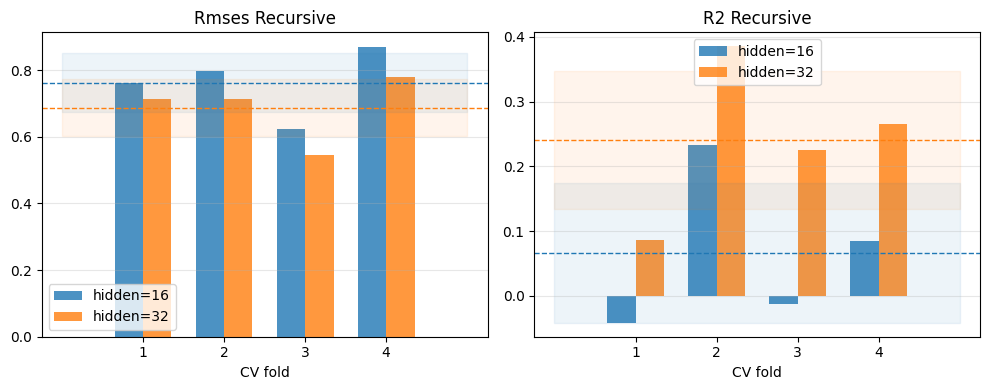

In [33]:

def plot_cv_comparison(results_a, results_b, label_a="model A", label_b="model B",
                       metrics=("rmses_recursive", "r2_recursive")):
    """
    results_*: dict-like with keys matching metrics and values = list/array per-fold.
               e.g. {'rmses_recursive': rmses_cv_at, 'r2_recursive': r2s_cv_at, ...}
    """
    n_metrics = len(metrics)
    fig, axes = plt.subplots(1, n_metrics, figsize=(5*n_metrics, 4))
    if n_metrics == 1:
        axes = [axes]

    for ax, metric in zip(axes, metrics):
        a = np.asarray(results_a[metric])
        b = np.asarray(results_b[metric])
        folds = np.arange(1, max(len(a), len(b)) + 1)

        # per-fold bars (align lengths)
        width = 0.35
        ax.bar(folds - width/2, a, width=width, label=label_a, alpha=0.8)
        ax.bar(folds + width/2, b, width=width, label=label_b, alpha=0.8)

        # mean ± std lines
        a_mean, a_std = np.nanmean(a), np.nanstd(a)
        b_mean, b_std = np.nanmean(b), np.nanstd(b)
        ax.axhline(a_mean, color='C0', linestyle='--', linewidth=1)
        ax.fill_between([0, folds[-1]+1], a_mean - a_std, a_mean + a_std, color='C0', alpha=0.08)
        ax.axhline(b_mean, color='C1', linestyle='--', linewidth=1)
        ax.fill_between([0, folds[-1]+1], b_mean - b_std, b_mean + b_std, color='C1', alpha=0.08)

        ax.set_xlabel("CV fold")
        ax.set_xticks(folds)
        ax.set_title(metric.replace("_", " ").title())
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Build result dicts from your CV outputs (example using existing names)
results1 = {
    "rmses_recursive": rmses_cv_at,
    "r2_recursive": r2s_cv_at,
}
results2 = {
    "rmses_recursive": rmses_cv_at2,
    "r2_recursive": r2s_cv_at2,
}

# Plot
plot_cv_comparison(results1, results2, label_a="hidden=16", label_b="hidden=32")


- performance appears more stable when hidden space dimension is 32 

In [34]:
model_at = build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at, lag_n, hidden_unit = 32)
history_at = model_at.fit(
    train_ds_at,
    epochs=50,
    validation_data=val_ds_at,
)


Epoch 1/50


236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2308 - mae: 0.3140 - rmse: 0.4713 - val_loss: 0.0737 - val_mae: 0.1827 - val_rmse: 0.2574
Epoch 2/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0798 - mae: 0.1766 - rmse: 0.2708 - val_loss: 0.0562 - val_mae: 0.1499 - val_rmse: 0.2247
Epoch 3/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0654 - mae: 0.1535 - rmse: 0.2458 - val_loss: 0.0487 - val_mae: 0.1374 - val_rmse: 0.2104
Epoch 4/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0604 - mae: 0.1458 - rmse: 0.2374 - val_loss: 0.0446 - val_mae: 0.1290 - val_rmse: 0.2025
Epoch 5/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0568 - mae: 0.1400 - rmse: 0.2314 - val_loss: 0.0458 - val_mae: 0.1325 - val_rmse: 0.2070
Epoch 6/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0539 - mae: 0.1345 - rmse: 0.2261 - val_loss: 0.0420 - val_mae: 0.1240 - val_rmse: 0.1986
Epoch 7/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0533 - mae: 0.1344 - rmse: 0.2257 - v

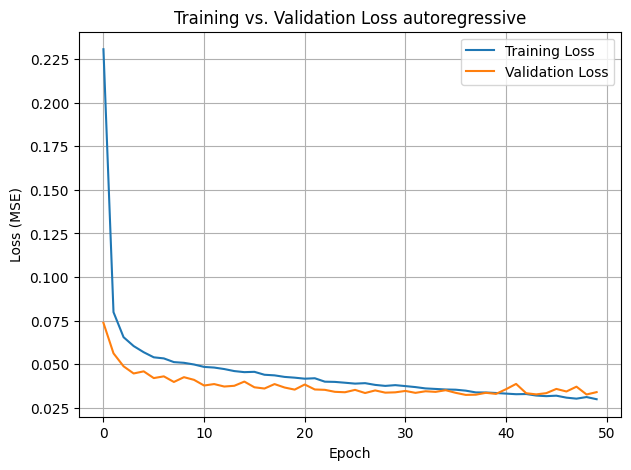

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
rmse: 0.182594, r2: 0.945574 


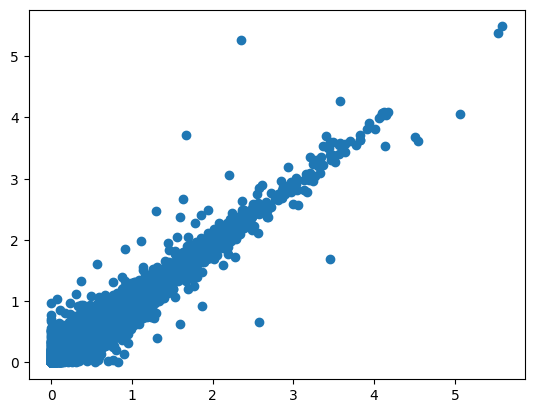

In [35]:


# Extract loss values
train_loss_at= history_at.history["loss"]
val_loss_at = history_at.history["val_loss"]

# Plot
plt.figure(figsize=(7, 5))
plt.plot(train_loss_at, label="Training Loss")
plt.plot(val_loss_at, label="Validation Loss")
plt.title("Training vs. Validation Loss autoregressive")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()




y_pred_val_1day_at= model_at.predict(val_ds_at)# show first few predictions

rmse_1day_at = root_mean_squared_error(y_pred_val_1day_at, val_y_at)
r2_1day_at = r2_score(val_y_at, y_pred_val_1day_at)
print(f'rmse: {rmse_1day_at:3f}, r2: {r2_1day_at:3f} ')
plt.scatter(val_y_at, y_pred_val_1day_at)

In [36]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at, y_val_at = compute_recursive_predictions_fast_LSTM(model_at, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)

In [37]:
r2_at = r2_score(y_val_at, y_pred_val_at)
rmse_at = root_mean_squared_error(y_val_at, y_pred_val_at)

print(f"r2: {r2_score(y_val_at, y_pred_val_at)}\n rmse: {root_mean_squared_error(y_val_at, y_pred_val_at)}")

r2: 0.5599374342826413
 rmse: 0.5308555162776171


/tmp/ipykernel_13578/262021228.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
/tmp/ipykernel_13578/262021228.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i+rmse_at for i in x_range], 'k--', lw=2, color="gold")
/tmp/ipykernel_13578/262021228.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i-rmse_at for i in x_range], 'k--', lw=2, color="gold")


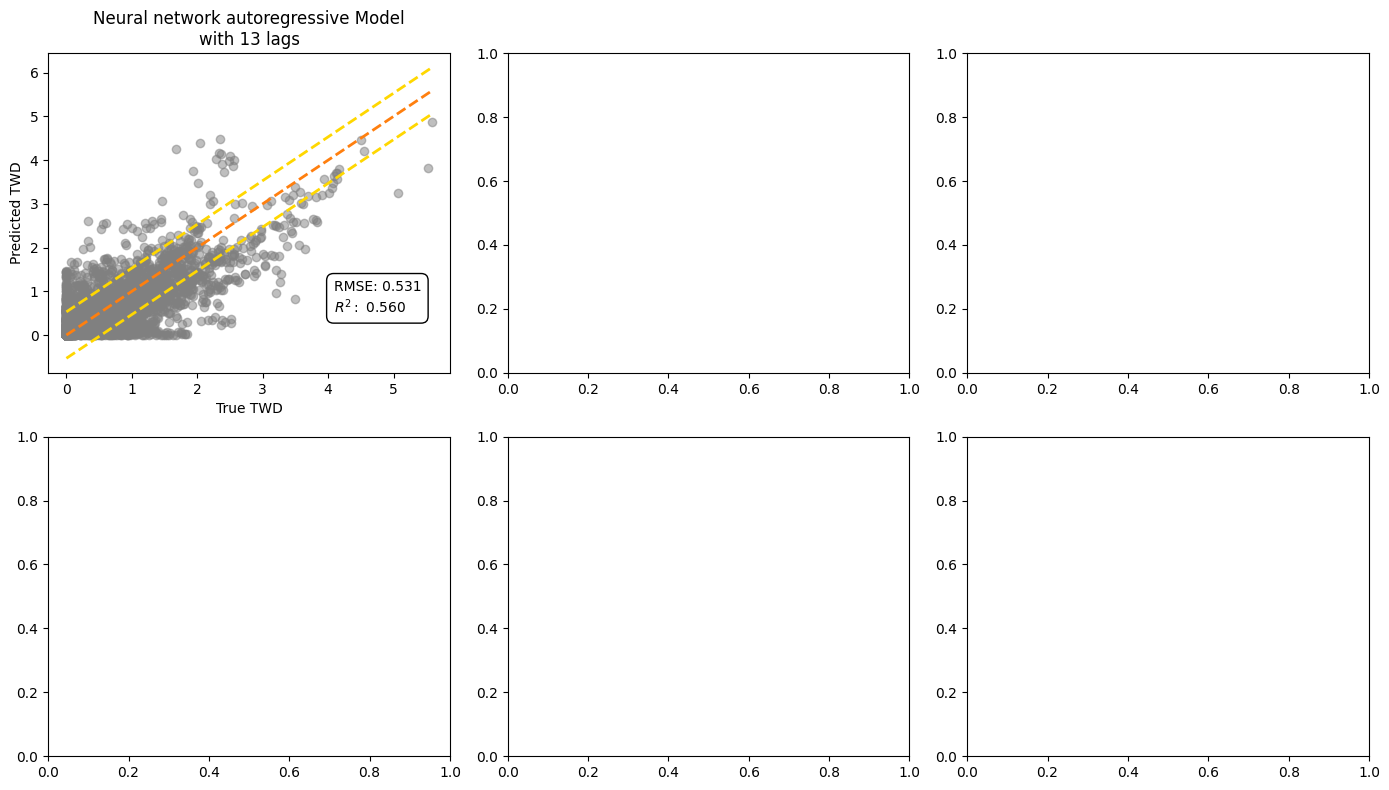

In [38]:
# Create figure with 3 subplots arranged in 1 row and 3 columns

def ensure_numpy(x):
    if isinstance(x, tf.Tensor):
        return x.numpy()
    return np.asarray(x)
val_y_at = ensure_numpy(val_y_at).reshape(-1)
y_pred_val_at = ensure_numpy(y_pred_val_at).reshape(-1)
# val_y = ensure_numpy(val_y)

fig, ((ax1, ax2, ax5), (ax3, ax4, _)) = plt.subplots(2, 3, figsize=(14, 8))

# First subplot - Autoregressive Model Predictions
ax1.scatter(x=y_val_at, y=y_pred_val_at, color="grey", alpha=0.5)
ax1.set_xlabel("True TWD")
ax1.set_ylabel("Predicted TWD")
x_range = [val_y_at.min(), val_y_at.max()]
ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax1.plot(x_range, [i+rmse_at for i in x_range], 'k--', lw=2, color="gold")
ax1.plot(x_range, [i-rmse_at for i in x_range], 'k--', lw=2, color="gold")
ax1.set_title(f"Neural network autoregressive Model\nwith {lag_n} lags")
ax1.text(val_y_at.max()-1.5,y_pred_val_at.min()+0.5, 
         f"RMSE: {rmse_at:.3f}\n$R^2:$ {r2_at:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


# # Second subplot - Residuals histogram
# y_res = train_y_at - model_at.predict(train_ds_at).reshape(-1)
# ax2.hist(y_res, bins=30, color='blue', alpha=0.7)
# ax2.set_xlabel("Residual")
# ax2.set_ylabel("Count")
# ax2.set_title("Residuals Distribution of autoregressive model")



# Third subplot - Lag-1 TWD relationship
# rmse_lag1 = root_mean_squared_error(val_df["twd"][:-1], val_df['twd'][1:])
# r2_score_lag1 = r2_score(val_df["twd"][:-1], val_df['twd'][1:])

# ax3.scatter(val_df["twd"][:-1], val_df['twd'][1:], color='tab:grey', alpha=0.5)
# ax3.set_xlabel("TWD at time t")
# ax3.set_ylabel("TWD at time t+1")
# ax3.set_title("TWD Lag-1 Relationship")
# ax3.text(val_df["twd"][:-1].max()-1.5, val_df['twd'][1:].min()+0.5, 
#          f"RMSE: {rmse_lag1:.3f}\nR2: {r2_score_lag1:.3f}", 
#          fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))



# # fourth subplot - non-Autoregressive Model Predictions
# ax4.scatter(x=val_y, y=y_pred_val_1day.reshape(-1), color="grey", alpha=0.5)
# ax4.set_xlabel("True TWD")
# ax4.set_ylabel("Predicted TWD")
# x_range = [val_y.min(), val_y.max()]
# ax4.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
# ax4.plot(x_range, [i+rmse_1day for i in x_range], 'k--', lw=2, color="gold")
# ax4.plot(x_range, [i-rmse_1day for i in x_range], 'k--', lw=2, color="gold")
# ax4.set_title(f"neural network non-autoregressive Model\nwith {lag_n} lags")
# ax4.text(val_y.max()-1.5,y_pred_val_1day.min()+0.5, 
#          f"RMSE: {rmse_1day:.3f}\n$R^2:$ {r2_1day:.3f}", 
#          fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))



# fourth subplot - non-Autoregressive Model Predictions
# ax5.scatter(x=val_y_at, y=y_pred_val_1day_at.reshape(-1), color="grey", alpha=0.5)
# ax5.set_xlabel("True TWD")
# ax5.set_ylabel("Predicted TWD")
# x_range = [val_y_at.min(), val_y_at.max()]
# ax5.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
# ax5.plot(x_range, [i+rmse_1day_at for i in x_range], 'k--', lw=2, color="gold")
# ax5.plot(x_range, [i-rmse_1day_at for i in x_range], 'k--', lw=2, color="gold")
# ax5.set_title(f"neural network autoregressive Model\nwith {lag_n} lags - performance on next day")
# ax5.text(val_y_at.max()-1.5,y_pred_val_1day_at.min()+0.5, 
#          f"RMSE: {rmse_1day_at:.3f}\n$R^2:$ {r2_1day_at:.3f}", 
#          fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))







# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### fine tune model with autoregressive training set 



add cross-validation

In [86]:
# build a fresh model with identical architecture
model_ar = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=32,
)

# copy weights from model_at (teacher-forced trained model)
model_ar.set_weights(model_at.get_weights())

# fine tune the model within CV

maes_cv_at_finetune, rmses_cv_at_finetune, rmses_cv_1d_at_finetune, r2s_cv_1d_at_finetune, \
r2s_cv_at_finetune, y_preds_cv_at_finetune, y_trues_cv_at_finetune, historys_cv_at_finetune = cross_validation_LSTM_FT(
    model_ar,
    train_val_datasets_at = train_val_datasets_at,
    lag_n = lag_n,
    config = config,
    num_epochs=50,
    batch_size = batch_size
)



Training fold 1/4
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2624 - mae: 0.3462 - rmse: 0.5117 - val_loss: 0.1675 - val_mae: 0.2572 - val_rmse: 0.4085
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2041 - mae: 0.3054 - rmse: 0.4512 - val_loss: 0.2590 - val_mae: 0.3226 - val_rmse: 0.5084
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1909 - mae: 0.2948 - rmse: 0.4363 - val_loss: 0.3298 - val_mae: 0.3621 - val_rmse: 0.5738
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1751 - mae: 0.2846 - rmse: 0.4178 - val_loss: 0.3743 - val_mae: 0.3848 - val_rmse: 0.6114
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1617 - mae: 0.2737 - rmse: 0.4014 - val_loss: 0.3950 - val_mae: 0.3935 - val_rmse: 0.6281
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1525 - mae: 0.2668 - rmse: 0.3898 - val_loss: 0.4187 - val_mae: 0.4034 - val_rmse: 0.6466
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1414 - mae: 0.2571 - 

In [39]:
X_dyn_ar, X_day_ar, X_static_ar, y_ar = build_autoregressive_training_data_fast_LSTM(
    model=model_at,
    df=train_df_at,
    feature_window_size=lag_n,
    label_window_size=1,
    shift=1,
    config=config,
    batch_size=64,
)

ds_ar = tf.data.Dataset.from_tensor_slices(
    ((X_dyn_ar, X_day_ar, X_static_ar), y_ar)
).batch(64).prefetch(tf.data.AUTOTUNE)

In [41]:
E2 = 50

# build a fresh model with identical architecture
model_ar = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=32,
)

# copy weights from model_at (teacher-forced trained model)
model_ar.set_weights(model_at.get_weights())

# now fine-tune on AR-corrupted dataset
model_ar.fit(
    ds_ar,
    epochs=E2,
    validation_data=val_ds_at
)


Epoch 1/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1962 - mae: 0.2872 - rmse: 0.4423 - val_loss: 0.0689 - val_mae: 0.1813 - val_rmse: 0.2615
Epoch 2/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1859 - mae: 0.2843 - rmse: 0.4305 - val_loss: 0.0697 - val_mae: 0.1787 - val_rmse: 0.2630
Epoch 3/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1804 - mae: 0.2815 - rmse: 0.4241 - val_loss: 0.0707 - val_mae: 0.1771 - val_rmse: 0.2650
Epoch 4/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1776 - mae: 0.2803 - rmse: 0.4208 - val_loss: 0.0713 - val_mae: 0.1758 - val_rmse: 0.2660
Epoch 5/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1746 - mae: 0.2790 - rmse: 0.4171 - val_loss: 0.0720 - val_mae: 0.1757 - val_rmse: 0.2672
Epoch 6/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1737 - mae: 0.2786 - rmse: 0.4161 - val_loss: 0.0739 - val_mae: 0.1767 - val_rmse: 0.2707
Epoch 7/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1705 - mae: 0.2763 - rmse:

In [ ]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at_FT, y_val_at_FT = compute_recursive_predictions_fast_LSTM(model_ar, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)

In [ ]:
r2_FT = r2_score(y_val_at_FT, y_pred_val_at_FT)
rmse_FT = root_mean_squared_error(y_val_at_FT, y_pred_val_at_FT)

print(f"r2: {r2_score(y_val_at_FT, y_pred_val_at_FT)}\n rmse: {root_mean_squared_error(y_val_at_FT, y_pred_val_at_FT)}")

r2: 0.02795003362308912
 rmse: 0.7889753162021595


### scheduled sampling - train model

cross validation - implement cross validation

In [118]:
num_epochs = 40

# init model with same architecture
model_at_ar_cv = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=32,
)
# copy weights from model_at (teacher-forced trained model)
model_at_ar_cv.set_weights(model_at.get_weights())

maes_cv_at_ar, rmses_cv_at_ar, rmses_cv_1d_at_ar, r2s_cv_1d_at_ar, \
r2s_cv_at_ar, y_preds_cv_at_ar, y_trues_cv_at_ar, historys_cv_at_ar = cross_validation_LSTM_AR(
    model_at_ar_cv,
    train_val_datasets_at = train_val_datasets_at,
    lag_n = lag_n,
    config = config,
    num_epochs=num_epochs,
    batch_size = batch_size,
    p_min = 0.1,
    warmup_epochs=2,
    frac_decay=0.2)




Training fold 1/4
Epoch 1/40 - loss: 0.0285 - rmse: 0.1672 - val_loss: 0.0979 - val_rmse: 0.3133 - p_tf: 1.000
Epoch 2/40 - loss: 0.0244 - rmse: 0.1545 - val_loss: 0.0966 - val_rmse: 0.3113 - p_tf: 1.000
Epoch 3/40 - loss: 0.0228 - rmse: 0.1491 - val_loss: 0.0923 - val_rmse: 0.3042 - p_tf: 1.000
Epoch 4/40 - loss: 0.0234 - rmse: 0.1512 - val_loss: 0.0830 - val_rmse: 0.2884 - p_tf: 0.850
Epoch 5/40 - loss: 0.0276 - rmse: 0.1645 - val_loss: 0.0831 - val_rmse: 0.2886 - p_tf: 0.700
Epoch 6/40 - loss: 0.0305 - rmse: 0.1731 - val_loss: 0.0709 - val_rmse: 0.2664 - p_tf: 0.550
Epoch 7/40 - loss: 0.0466 - rmse: 0.2146 - val_loss: 0.1376 - val_rmse: 0.3719 - p_tf: 0.400
Epoch 8/40 - loss: 0.0847 - rmse: 0.2900 - val_loss: 0.0893 - val_rmse: 0.2994 - p_tf: 0.250
Epoch 9/40 - loss: 0.1970 - rmse: 0.4432 - val_loss: 0.4911 - val_rmse: 0.7039 - p_tf: 0.100
Epoch 10/40 - loss: 0.3102 - rmse: 0.5564 - val_loss: 0.2198 - val_rmse: 0.4705 - p_tf: 0.100
Epoch 11/40 - loss: 0.3108 - rmse: 0.5569 - val_los

2025-12-14 17:00:51.642260: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 30/40 - loss: 0.0662 - rmse: 0.2550 - val_loss: 0.0921 - val_rmse: 0.3032 - p_tf: 0.100
Epoch 31/40 - loss: 0.0718 - rmse: 0.2659 - val_loss: 0.1058 - val_rmse: 0.3252 - p_tf: 0.100
Epoch 32/40 - loss: 0.0810 - rmse: 0.2829 - val_loss: 0.0923 - val_rmse: 0.3036 - p_tf: 0.100
Epoch 33/40 - loss: 0.0975 - rmse: 0.3102 - val_loss: 0.1133 - val_rmse: 0.3366 - p_tf: 0.100
Epoch 34/40 - loss: 0.0840 - rmse: 0.2881 - val_loss: 0.0968 - val_rmse: 0.3110 - p_tf: 0.100
Epoch 35/40 - loss: 0.0861 - rmse: 0.2917 - val_loss: 0.1144 - val_rmse: 0.3383 - p_tf: 0.100
Epoch 36/40 - loss: 0.0771 - rmse: 0.2754 - val_loss: 0.1054 - val_rmse: 0.3246 - p_tf: 0.100
Epoch 37/40 - loss: 0.0775 - rmse: 0.2762 - val_loss: 0.1181 - val_rmse: 0.3437 - p_tf: 0.100
Epoch 38/40 - loss: 0.0716 - rmse: 0.2654 - val_loss: 0.1012 - val_rmse: 0.3178 - p_tf: 0.100
Epoch 39/40 - loss: 0.0742 - rmse: 0.2701 - val_loss: 0.1183 - val_rmse: 0.3440 - p_tf: 0.100
Epoch 40/40 - loss: 0.0730 - rmse: 0.2681 - val_loss: 0.1088

In [ ]:
# now do scheduled sampling training on the full training set
num_epochs = 80

history_ar_at = {
"loss": [],
"rmse": [],
"val_loss": [],
"val_rmse": [],
"p_tf": []
}


# init model with same architecture
model_at_ar = build_autoregressive_model_lstm(
    train_X_ts_at,
    train_day_feat_X_at,
    train_static_X_ts_at,
    lag_n=lag_n,
    hidden_unit=32,
)
# copy weights from model_at (teacher-forced trained model)
model_at_ar.set_weights(model_at.get_weights())



for epoch in range(num_epochs):
        # train model with teacher forcing for the first epoch 
    p_tf = teacher_forcing_prob(epoch, num_epochs, p0=1.0, p_min=0.1, warmup_epochs=5, frac_decay=0.8)
    history_ar_at["p_tf"].append(p_tf)

    # rebuild AR / scheduled-sampling training data
    X_dyn_ar_at, X_day_ar_at, X_static_ar_at, y_ar_at = build_autoregressive_training_data_fast_LSTM_scheduled(
        model_at_ar,
        train_df_at,
        feature_window_size=lag_n,
        label_window_size=1,
        shift=1,
        config=config,
        batch_size=batch_size,
        teacher_forcing_prob=p_tf,
    )

    train_ds_at_decay = (
        tf.data.Dataset.from_tensor_slices(((X_dyn_ar_at, X_day_ar_at, X_static_ar_at), y_ar_at))
        .shuffle(len(X_dyn_ar_at))
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    # one epoch of manual training
    epoch_loss = tf.keras.metrics.Mean()
    epoch_rmse = tf.keras.metrics.RootMeanSquaredError()

    for (x_dyn, x_day, x_stat), y in train_ds_at_decay:
        with tf.GradientTape() as tape:
            preds = model_at_ar([x_dyn, x_day, x_stat], training=True)
            loss = model_at_ar.compute_loss(x=None, y=y, y_pred=preds, sample_weight=None, training=True)

        grads = tape.gradient(loss, model_at_ar.trainable_variables)
        model_at_ar.optimizer.apply_gradients(zip(grads, model_at_ar.trainable_variables))      
        epoch_loss.update_state(loss)
        epoch_rmse.update_state(y, preds)

    # validation
    val_loss_metric = tf.keras.metrics.Mean()
    val_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    for (x_dyn_v, x_day_v, x_stat_v), y_v in val_ds_at:
        preds_v = model_at_ar([x_dyn_v, x_day_v, x_stat_v], training=False)
        v_loss = model_at_ar.compute_loss(x=None, y=y_v, y_pred=preds_v, sample_weight=None, training=False)
        val_loss_metric.update_state(v_loss)
        val_rmse_metric.update_state(y_v, preds_v)

    history_ar_at["loss"].append(epoch_loss.result().numpy())
    history_ar_at["rmse"].append(epoch_rmse.result().numpy())
    history_ar_at["val_loss"].append(val_loss_metric.result().numpy())
    history_ar_at["val_rmse"].append(val_rmse_metric.result().numpy())
    history_ar_at["p_tf"].append(p_tf)

    print(
        f"Epoch {epoch+1}/{num_epochs} - "
        f"loss: {history_ar_at['loss'][-1]:.4f} - rmse: {history_ar_at['rmse'][-1]:.4f} - "
        f"val_loss: {history_ar_at['val_loss'][-1]:.4f} - val_rmse: {history_ar_at['val_rmse'][-1]:.4f} - "
        f"p_tf: {p_tf:.3f}"
    )

Epoch 1/80 - loss: 0.0294 - rmse: 0.1700 - val_loss: 0.0350 - val_rmse: 0.1855 - p_tf: 1.000
Epoch 2/80 - loss: 0.0289 - rmse: 0.1684 - val_loss: 0.0355 - val_rmse: 0.1871 - p_tf: 1.000


2025-12-14 13:42:02.502166: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3/80 - loss: 0.0288 - rmse: 0.1680 - val_loss: 0.0328 - val_rmse: 0.1797 - p_tf: 1.000
Epoch 4/80 - loss: 0.0288 - rmse: 0.1683 - val_loss: 0.0344 - val_rmse: 0.1839 - p_tf: 1.000
Epoch 5/80 - loss: 0.0283 - rmse: 0.1666 - val_loss: 0.0347 - val_rmse: 0.1849 - p_tf: 1.000
Epoch 6/80 - loss: 0.0274 - rmse: 0.1639 - val_loss: 0.0341 - val_rmse: 0.1834 - p_tf: 1.000
Epoch 7/80 - loss: 0.0286 - rmse: 0.1673 - val_loss: 0.0354 - val_rmse: 0.1867 - p_tf: 0.985
Epoch 8/80 - loss: 0.0287 - rmse: 0.1680 - val_loss: 0.0370 - val_rmse: 0.1911 - p_tf: 0.969
Epoch 9/80 - loss: 0.0273 - rmse: 0.1638 - val_loss: 0.0350 - val_rmse: 0.1858 - p_tf: 0.954
Epoch 10/80 - loss: 0.0279 - rmse: 0.1654 - val_loss: 0.0345 - val_rmse: 0.1843 - p_tf: 0.939
Epoch 11/80 - loss: 0.0280 - rmse: 0.1657 - val_loss: 0.0338 - val_rmse: 0.1826 - p_tf: 0.924
Epoch 12/80 - loss: 0.0281 - rmse: 0.1663 - val_loss: 0.0344 - val_rmse: 0.1842 - p_tf: 0.908
Epoch 13/80 - loss: 0.0286 - rmse: 0.1676 - val_loss: 0.0350 - val_

2025-12-14 14:30:14.062589: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 67/80 - loss: 0.1826 - rmse: 0.4259 - val_loss: 0.2845 - val_rmse: 0.5324 - p_tf: 0.100
Epoch 68/80 - loss: 0.1636 - rmse: 0.4031 - val_loss: 0.3503 - val_rmse: 0.5911 - p_tf: 0.100
Epoch 69/80 - loss: 0.1588 - rmse: 0.3972 - val_loss: 0.2348 - val_rmse: 0.4834 - p_tf: 0.100
Epoch 70/80 - loss: 0.1322 - rmse: 0.3620 - val_loss: 0.3122 - val_rmse: 0.5579 - p_tf: 0.100
Epoch 71/80 - loss: 0.1377 - rmse: 0.3696 - val_loss: 0.2265 - val_rmse: 0.4748 - p_tf: 0.100
Epoch 72/80 - loss: 0.1253 - rmse: 0.3521 - val_loss: 0.3245 - val_rmse: 0.5688 - p_tf: 0.100
Epoch 73/80 - loss: 0.1335 - rmse: 0.3637 - val_loss: 0.2521 - val_rmse: 0.5012 - p_tf: 0.100
Epoch 74/80 - loss: 0.1247 - rmse: 0.3517 - val_loss: 0.3875 - val_rmse: 0.6219 - p_tf: 0.100
Epoch 75/80 - loss: 0.1397 - rmse: 0.3722 - val_loss: 0.2597 - val_rmse: 0.5086 - p_tf: 0.100
Epoch 76/80 - loss: 0.1207 - rmse: 0.3459 - val_loss: 0.3364 - val_rmse: 0.5792 - p_tf: 0.100
Epoch 77/80 - loss: 0.1299 - rmse: 0.3590 - val_loss: 0.2352

In [ ]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_at_ar, y_val_at_ar= compute_recursive_predictions_fast_LSTM(model_at_ar, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)
r2_at_ar = r2_score(y_val_at_ar, y_pred_val_at_ar)
rmse_at_ar = root_mean_squared_error(y_val_at_ar, y_pred_val_at_ar)

print(f"r2: {r2_at_ar}\n rmse: {rmse_at_ar}")

r2: -1.2539155994429767
 rmse: 1.2014008807964094


In [127]:
maes_cv_at_ar, rmses_cv_at_ar
# rmses_cv_1d_at_ar, r2s_cv_1d_at_ar,
# r2s_cv_at_ar, y_preds_cv_at_ar, y_trues_cv_at_ar,
[i for i in range(1, len(maes_cv_at_ar) + 1)] *4

[1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]

In [131]:
# plot performance together

df_model_performance = pd.DataFrame({
    "model" :['teacher_forcing (hidden=16)'] *4 + ['teacher_forcing (hidden=32)'] *4 + ['fine_tuned (hidden=32)'] *4 + ['scheduled_sampling (hidden=32)'] *4,    
    "cv_fold"  : [i for i in range(1, len(maes_cv_at_ar) + 1)] *4,
    "mae": maes_cv_at + maes_cv_at2 + maes_cv_at_finetune + maes_cv_at_ar,
    "rmse_recursive": rmses_cv_at + rmses_cv_at2 + rmses_cv_at_finetune + rmses_cv_at_ar,
    "rmse_1day": rmses_cv_1d_at + rmses_cv_1d_at2 + rmses_cv_1d_at_finetune + rmses_cv_1d_at_ar,
    "r2_1day" : r2s_cv_1d_at + r2s_cv_1d_at2 + r2s_cv_1d_at_finetune + r2s_cv_1d_at_ar,
    "r2_recursive": r2s_cv_at + r2s_cv_at2 + r2s_cv_at_finetune + r2s_cv_at_ar,
}
)

df_model_p_long = df_model_performance.melt(id_vars=["model", "cv_fold"], 
                                        value_vars=["mae", "rmse_recursive", "rmse_1day", "r2_1day", "r2_recursive"],
                                        var_name="metric",
                                        value_name="value"
                                        )

In [134]:
df_model_p_long 

,model,cv_fold,metric,value
0,teacher_forcing (hidden=16),1,mae,0.240809
1,teacher_forcing (hidden=16),2,mae,0.206019
2,teacher_forcing (hidden=16),3,mae,0.124775
3,teacher_forcing (hidden=16),4,mae,0.163898
4,teacher_forcing (hidden=32),1,mae,0.186907
...,...,...,...,...
75,fine_tuned (hidden=32),4,r2_recursive,0.051677
76,scheduled_sampling (hidden=32),1,r2_recursive,-0.472194
77,scheduled_sampling (hidden=32),2,r2_recursive,0.367531
78,scheduled_sampling (hidden=32),3,r2_recursive,0.088497


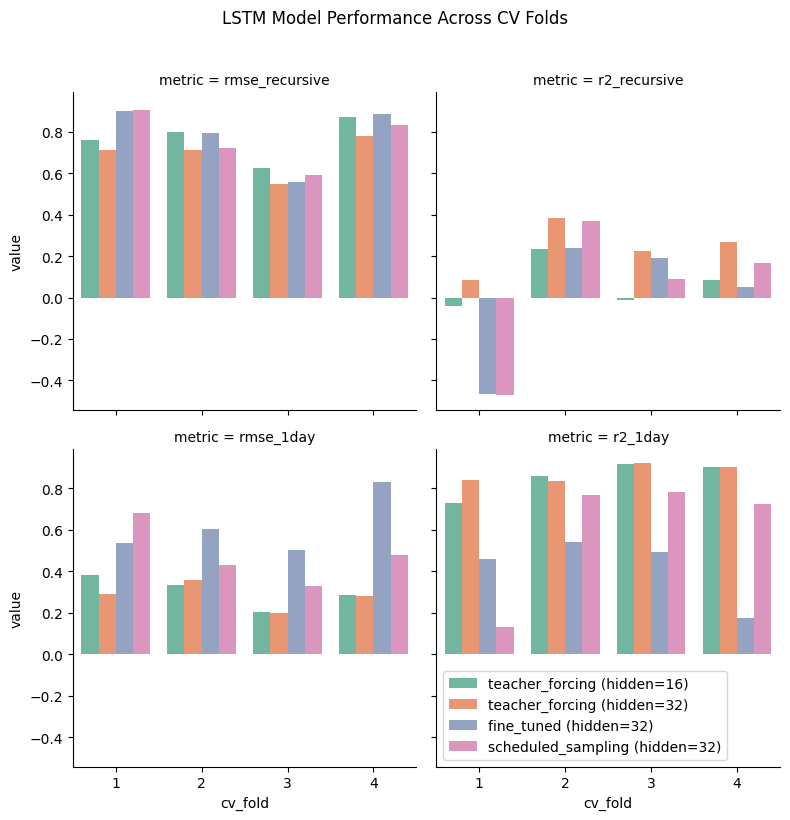

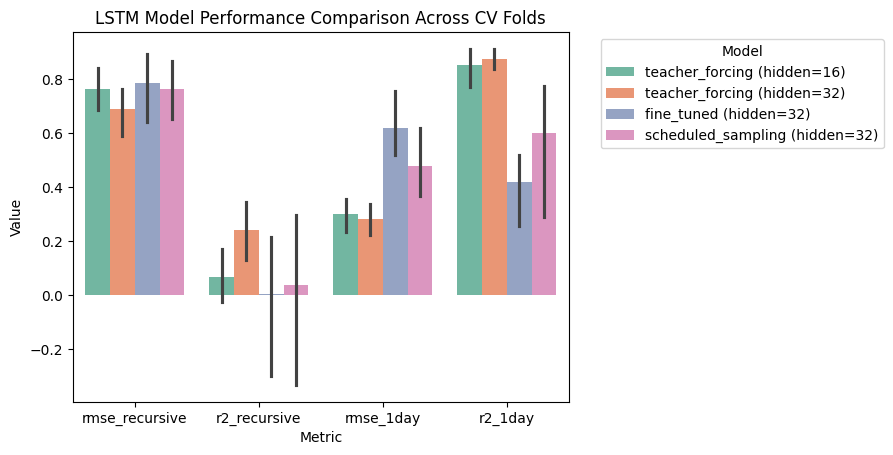

In [155]:
metrics_plot = ['rmse_recursive', 'r2_recursive', 'rmse_1day', 'r2_1day']
df_p_plot = df_model_p_long.loc[df_model_p_long['metric'].isin(
metrics_plot
)]  
g = sns.FacetGrid(df_p_plot, col="metric", col_wrap = 2,
              col_order = metrics_plot,
              height=4, sharey=True).map_dataframe(
    sns.barplot,
    x="cv_fold",
    y="value",
    hue = 'model',
    palette = "Set2",
    legend = True,
)

g.figure.suptitle("LSTM Model Performance Across CV Folds", y=1.02)


plt.tight_layout()
plt.legend()
plt.show()

sns.barplot(df_p_plot, x="metric", y="value", hue="model", palette="Set2",
            order = metrics_plot)
plt.title("LSTM Model Performance Comparison Across CV Folds")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1))
plt.show()


why the performance is so bad ..

to improve the model performance
- we can try to improve the LSTM architecture 
    -  added softplus - why it lowered the performance? 
    - play with the architecture and hyperparameter
- add also compute the correlation matrix of lagged features with twd
- should I create cross-validation function to choose the tune the model?
- how can i integrate autoregressive training?
- incorporate log value into traning 
- stack layers? 
- how to extrapolate if i use location and other static parameters in the future?
- perturbation to analyze feature importance